In [ ]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from keras.models import Sequential
from keras.layers import Embedding,Dense, Lambda
import keras.backend as K
from keras.layers import Input
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.text import Tokenizer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [ ]:
remove_terms = punctuation + "0123456789"
remove_terms

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [ ]:
def preprocessing(text):
    words = word_tokenize(text,)
    tokens = [w for w in words if w.lower() not in remove_terms]
    #stopw = stopwords.words('english')
    #tokens = [token for token in tokens if token not in stopw]
    #remove words less than three letters
    #tokens = [word for word in tokens if len =(word)>=3]
    #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
corpus = open('/content/stock_sentiment.csv', encoding="utf8").readlines()

In [ ]:
corpus = [preprocessing(sentence) for sentence in corpus if sentence.strip() !='']
corpus

['Text Sentiment',
 'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method or method see prev post',
 'user AAP MOVIE return for the indicator just trade for the year AWESOME',
 'user I be afraid to short AMZN they are looking like a in eBooks and',
 'MNTA Over',
 'OI Over',
 'PGNX Over',
 'AAP user if so then the current downtrend will break Otherwise just a correction in',
 'Monday relative weakness NYX WIN TIE TAP ICE INT BMC AON C CHK BIIB',
 'GOOG ower trend line channel test volume support',
 'AAP will watch tomorrow for ONG',
 'i assuming FCX open tomorrow above the trigger buy still very much like this setup',
 'It really worry me how everyone expects the market to rally now usually exact opposite happens every time we shall see soon bac spx jpm',
 'AAP GAMCO arry Haverty Apple Is Extremely Cheap Great Video',
 'user Maykiljil posted that I agree that MSFT is going higher possibly north of',
 'Momentum is coming back to ETFC Broke resistance on solid volume Friday on

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(corpus)

In [ ]:
X_train_tokens = tokenizer.texts_to_sequences(corpus)

In [ ]:
word2id = tokenizer.word_index
id2word= dict([(value,key) for (key,value)  in word2id.items()])

In [ ]:
vocab_size = len(word2id) + 1
vocab_size

7465

In [ ]:
embed_size = 300
window_size = 2

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            context_words.append([words[i] 
                                  for i in range(start, end)
                                  if 0 <= i < sentence_length
                                  and i != index])
            
            label_word.append(word)
            x= pad_sequences(context_words, maxlen= context_length)
            y = to_categorical(label_word, vocab_size)
            yield (x,y)

In [ ]:
i = 0
for x,y in generate_context_word_pairs(corpus=X_train_tokens, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '--> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['kickers', 'on', 'watchlist', 'xide'] --> Target (Y): my
Context (X): ['on', 'my', 'xide', 'tit'] --> Target (Y): watchlist
Context (X): ['my', 'watchlist', 'tit', 'soq'] --> Target (Y): xide
Context (X): ['watchlist', 'xide', 'soq', 'pnk'] --> Target (Y): tit
Context (X): ['xide', 'tit', 'pnk', 'cpw'] --> Target (Y): soq
Context (X): ['tit', 'soq', 'cpw', 'bpz'] --> Target (Y): pnk
Context (X): ['soq', 'pnk', 'bpz', 'aj'] --> Target (Y): cpw
Context (X): ['pnk', 'cpw', 'aj', 'trade'] --> Target (Y): bpz
Context (X): ['cpw', 'bpz', 'trade', 'method'] --> Target (Y): aj
Context (X): ['bpz', 'aj', 'method', 'or'] --> Target (Y): trade
Context (X): ['aj', 'trade', 'or', 'method'] --> Target (Y): method


In [ ]:
model = Sequential()

In [ ]:
model.add(Embedding(input_dim=vocab_size, output_dim= embed_size,
                         embeddings_initializer='glorot_uniform',
                         input_length=window_size*2))

In [ ]:
model.add(Lambda(lambda x: K.mean(x, axis = 1), output_shape = (embed_size)))

In [ ]:
model.add(Dense(vocab_size, kernel_initializer= 'glorot_uniform', activation = 'softmax'))

In [ ]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 300)            2239500   
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 7465)              2246965   
Total params: 4,486,465
Trainable params: 4,486,465
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.1)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = opt)

In [ ]:
n_epochs = 5
for epoch in range (n_epochs):
    loss = 0.
    for x, y in generate_context_word_pairs(corpus = X_train_tokens, window_size=window_size, vocab_size = vocab_size):
        loss += model.train_on_batch(x,y)
    print ('Epoch:', epoch, '\tloss:', loss)

Epoch: 0 	loss: 2932854.77923534


KeyboardInterrupt: ignored

In [ ]:
# Word Embedding Vectors:
weights = model.get_weights()[0]
weights = weights[1:]
print(weights.shape)

(7464, 300)


In [ ]:
pd.DataFrame(weights, index = list(id2word.values())).head(30)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
the,0.898756,-1.934289,-1.743661,0.857197,-0.123760,-0.671923,-0.000294,-1.573424,0.087034,1.793865,1.044924,-1.651438,0.539306,0.085453,-0.588175,-1.152048,-0.325722,0.190585,1.221235,-0.732463,0.751481,1.181155,-1.862905,-0.070613,-1.308390,-0.854225,1.669793,-0.766212,-1.935004,0.593116,-1.330874,1.061117,-1.977004,3.310038,-2.966766,-1.000666,-0.782300,-1.490018,-0.892555,-0.230199,...,-1.680205,-0.188017,-0.560169,-1.069777,-0.442554,-0.449930,0.805841,-1.341613,2.192414,0.151086,0.425545,-1.972614,-0.304631,0.627911,-0.703230,-0.125962,1.184343,-0.801968,-1.741063,0.140962,-1.495066,0.604560,2.233131,-0.306159,1.063274,-1.870916,-0.206575,1.989215,0.335814,-0.126692,-1.387072,-0.786571,0.358654,1.032749,-1.305424,1.307613,2.789392,0.947963,-0.043133,1.920884
to,-1.456559,0.950521,-0.407582,-2.656812,-1.177730,1.202332,0.567464,-0.434366,-0.872463,-0.214415,0.556118,0.590826,2.378801,-1.139800,-1.532301,-1.265056,-2.058658,0.783492,-1.320708,2.339106,-2.620031,1.058273,1.193045,-0.844085,1.118871,-0.758753,1.749433,1.606628,-0.709374,0.748049,-0.300165,-0.653877,-0.678506,-0.858375,1.298113,-0.648347,0.030643,-0.274524,-0.473018,-0.746731,...,-0.541071,-0.489653,-1.033612,0.268046,-0.636825,0.492219,0.767307,0.058505,-1.517748,-2.225499,-1.328057,1.687918,0.855206,0.600964,-0.396732,-0.239909,-1.084360,0.427164,2.209431,1.392718,0.108875,0.436859,-0.270790,1.504476,-2.010149,0.868079,0.714454,3.310430,-0.780871,-0.454083,0.413051,1.944258,1.149413,-1.757730,-1.020090,-0.641789,-0.223102,2.640656,-0.163592,1.375150
a,2.032210,-0.847247,2.109975,2.067204,-1.677394,-0.290143,0.291701,0.019414,1.278524,-0.156031,-0.325311,-0.788699,1.257478,-1.924046,0.188538,1.471229,1.045611,0.968016,-1.115086,-0.099486,1.911699,-0.655302,-0.438029,1.462183,1.639039,-0.641574,0.939278,0.107864,3.227448,-0.512598,0.062678,0.596491,-1.687099,0.238216,-0.688478,-1.980595,1.278495,0.363234,-0.842114,-1.345757,...,0.480346,2.193462,1.957882,-0.225951,0.556386,1.491247,1.058533,-0.312306,0.152834,1.281432,1.192775,-1.197650,-0.834101,0.208598,2.113934,-0.904044,1.201372,-1.066879,1.742063,0.844918,-0.882967,1.872593,-1.152108,-1.512808,1.864655,-0.455073,-1.047275,-0.571509,1.723513,1.794833,-2.878797,-0.422828,0.163723,0.281119,0.720177,-0.634673,-1.527971,-0.142381,-0.441484,1.921221
on,0.293655,-0.965105,-2.888290,-1.454347,-0.470007,-1.276081,1.059499,-0.812216,0.033693,-0.257237,-1.107810,0.227935,0.318281,1.773172,-0.627612,-0.700538,-1.308247,-0.268901,-0.713458,0.574145,-0.573731,-0.212091,0.862356,-0.637751,1.367694,1.034736,0.605459,0.173853,0.105852,-0.832065,0.621099,-0.610426,0.114396,-0.974062,0.254147,-1.077048,0.650094,0.649549,3.397891,-0.451386,...,-0.689634,-0.486520,-0.613405,-0.184223,0.928449,1.151334,-0.481779,0.855974,-1.115757,-1.450359,1.196437,-2.385051,0.573008,0.294802,-0.480651,0.399177,-0.213141,-0.059516,0.481982,1.302258,-0.536354,-1.322893,-1.355073,-3.362815,-1.128574,-0.038595,0.167155,-1.065127,1.620797,-2.081441,1.167419,-1.771887,0.042134,-0.652303,-0.799201,-0.334969,1.194577,0.294895,-1.946163,0.689331
in,2.724529,-0.736741,1.273131,1.195527,-1.847520,-1.693743,0.263948,-0.300538,-1.648850,0.200258,0.979164,-0.457581,0.988770,0.397552,-0.089688,1.252328,-1.211178,1.046384,-0.808354,3.060567,-0.809927,-1.388965,0.685092,1.007993,1.013637,-2.202137,0.307818,-1.204621,-2.233025,-0.124410,0.918036,0.099547,-0.773054,0.389789,2.315950,0.077935,-0.831638,-1.437008,-0.580526,1.001698,...,-1.287482,-0.794764,-0.726479,-0.250277,-2.120728,1.073934,1.065053,2.520576,-0.996937,-0.290390,-0.014524,1.787038,0.709956,0.625704,1.006943,-1.648401,1.002322,-1.296380,-0.371406,-1.701252,-0.972778,1.883037,1.669911,-1.031102,-1.348189,-0.556677,0.119134,0

In [ ]:
# Similar Words
distance_matrix = cosine_similarity(weights)
print(distance_matrix.shape)

(7464, 7464)


In [ ]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                 for search_term in ['ibm', 'cash']}
similar_words

{'cash': ['you', 'blow', 'flow', 'el', 'alright'],
 'ibm': ['yeehaw', 'worries', 'been', 'accelerate', 'no']}

In [ ]:
# Visualizing words relationships:
words = sum([[k]+ v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total Words:', len(words), '\tword Embedding Shapes:', word_vectors.shape)

Total Words: 12 	word Embedding Shapes: (12, 300)


In [ ]:
tsne = TSNE(n_components=2, random_state=2018, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

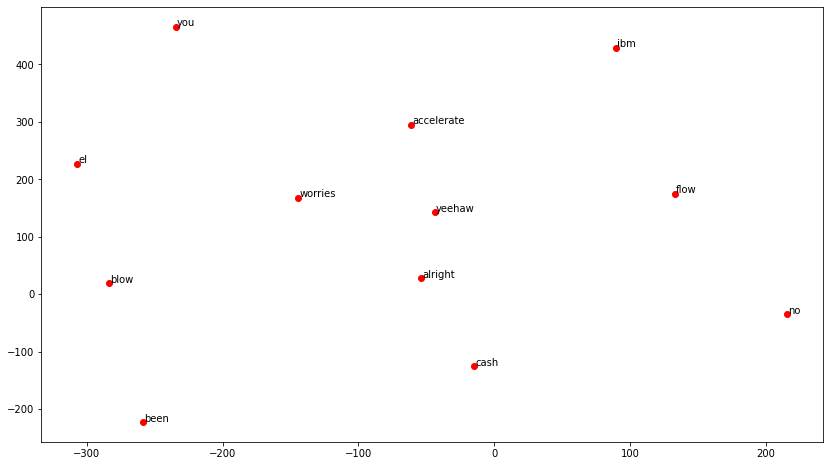

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(T[:,0], T[:,1], c='red')
for label, x,y in zip (labels, T[:,0], T[:,1]):
    plt.annotate(label, xy=(x+1,y+1), xytext=(0,0),textcoords='offset points')